# Projet 1: Descente de gradient

## Question 1

### Importation des packages

In [3]:
from math import *
import random
import numpy as np
from numpy.random import multivariate_normal, randn # Probability distributions on vectors

import pandas as pd  #pandas pour la gestion des données 
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, mean_squared_error
# SciPy - Efficient mathematical calculation
from scipy.linalg.special_matrices import toeplitz # A special kind of matrices
from scipy.linalg import svdvals # Singular values
from scipy.linalg import norm # Euclidean norm
from scipy.optimize import check_grad # Check accuracy between objective and gradient values
from scipy.optimize import fmin_l_bfgs_b # Efficient optimizer

### Génération de la base de données

J'ai décidé de travailler sur un dataset que j'ai généré aléatoirement composé de 6 variables décorrélées. 
Connaissant les coefficients de régression, il est aussi plus simple de s'assurer du bon fonctionnement de la méthode et de l'implémentation de l'algorithme de descente de gradient.

In [53]:
np.random.seed(1)
n=1000
nbr_var=6
x=np.zeros((n,nbr_var))
sd=10
mu=50
for i in range(nbr_var):
  x[:,i]= np.random.randn(n)*sd+mu
design=pd.DataFrame(x,columns = ['X1', 'X2', 'X3', 'X4', 'X5', 'X6'])
coef=np.array([6,4,0.8,0.02,7,3.8]).reshape(-1,1)
y=np.dot(design,coef)+np.random.randn(n).reshape(-1,1)

In [54]:
dataset=design
dataset

,X1,X2,X3,X4,X5,X6
0,66.243454,48.467638,54.895166,49.228930,48.596290,40.752447
1,43.882436,25.674915,52.387959,52.078253,51.416417,61.288899
2,44.718282,55.079843,45.518882,59.861959,53.119686,38.712087
3,39.270314,46.759677,43.892050,64.327564,57.690852,42.752624
4,58.654076,34.889234,29.700549,55.282585,55.842858,56.235712
...,...,...,...,...,...,...
995,48.835559,51.885829,42.281095,48.740969,66.045462,52.246046
996,27.227020,55.609181,43.773434,40.396536,55.666131,45.228558
997,49.303755,40.783409,48.493404,41.560867,42.240122,43.087882
998,53.538704,56.473751,35.999771,56.283417,60.848887,42.112688


Nous obtenons la matrice de corrélation suivante.

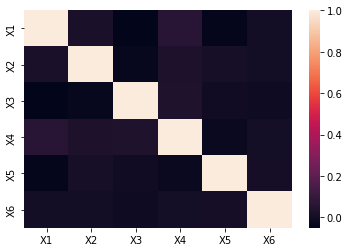

In [55]:

#Matrice de corrélation
corrMatrix = dataset.corr()
sn.heatmap(corrMatrix, annot=False)
plt.show()

### Séparation du training et du test set

In [56]:
#Séparation du training set et du test set
X_train,X_test,y_train,y_test=train_test_split(design,y,test_size=0.33, random_state=1)



### Détermination de la borne supérieure pour le learningrate

In [57]:
#Plus grand valeur propre de la matrice de XX.T
max_ev=max(np.linalg.eigvals(np.dot(X_train, X_train.T))).real
# Nous obtenons la borne supérieur du pas que nous pouvons utilisant grace au résulat théorique suivant 
step=1/max_ev
step

9.861533615619182e-08

## Question 2

### Définition de la fonction de perte ridge et algorithme de descente de gradient

In [58]:
# Définition de la fonction de perte
def ridge_error(y,X,beta,lambd):
  return(((np.dot(X,beta)-y)**2).sum()/2+lambd*(beta**2).sum()/2)/len(y)

In [59]:
def gradient_descent_ridge(X, y,lambd, learningrate=1e-3, epochs=10000,epsilon=1e-2,monit=True,arret=True):

  """
  Algorithme de descent de gradient avec pénalité ridge
  
  Parametres
  ----------
  X : np.array
    matrice de design

  y : np.array
    vecteur du target

  lambd: float
    parametre de régularisation

  epochs: int
    Nombre d'epochs


  monit : bool
      Affiche l'itération en cours


  
  arret : bool
      Algorithme s'arrete lorsque la condition d'arret est satisfaite

  epsilon : float
      Paramètre de précision pour la condition d'arret
  """  
  ridge=[]
  beta = pd.DataFrame([0,0,0,0,0,0]) # Initialisation des coefficients
  for i in range(epochs+1):
    if i%(epochs/100)==0 and monit: #monitoring
      print("itération {} en cours ...".format(i))
    # Updating beta
    delta =  np.subtract(np.dot(X,beta),y.reshape(-1,1))
    gradient=np.dot(X.T,delta)+ lambd*beta
    beta_new= beta-learningrate * gradient # on retire un gradient
    ridge.append(ridge_error(y,X,beta_new,lambd)) # on calcule l'erreur
    
    if np.linalg.norm(gradient)<epsilon and arret: #condition d'arrêt
      print("L'algorithme a convergé ")
      break
    beta=beta_new
    
  return beta,ridge

### Vitesse de convergence de la descente de gradient

Nous tracons le graphique de la log fonction de perte en fonction du nombre d'itérations. Nous pouvons ainsi observer la vitesse de convergence.

Text(0.5, 1.0, "Fonction de perte ridge en fonction du nombre d'itération")

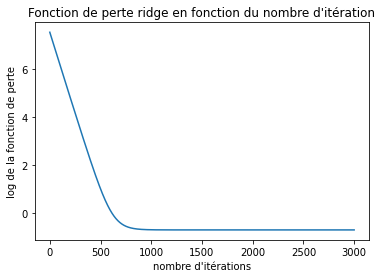

In [60]:
beta,ridge=gradient_descent_ridge(X_train,y_train,lambd=0.3,learningrate=1*step, epochs=3000,epsilon=1e-3,monit=False)
plt.plot(np.log(ridge))
plt.xlabel("nombre d'itérations")
plt.ylabel("log de la fonction de perte")
plt.title("Fonction de perte ridge en fonction du nombre d'itération")

In [42]:
coef

array([[6.  ],
       [4.  ],
       [0.8 ],
       [0.02],
       [7.  ],
       [3.8 ]])

In [61]:
beta

,0
0,5.997643
1,3.995093
2,0.811739
3,0.015615
4,6.997811
5,3.801480


Les paramètres trouvés par l'algorithme de descent de gradient sont très proches des paramètres réels.

## Question 3

On trace les vitesses de convergence de l'algorithme pour différentes valeurs de learning rate. Nous notons step l'inverse de la plus grande valeur propre. Dans la théorie, le gradient converge lorsque le learningrate est inférieure à $2 \times$step et diverge sinon.

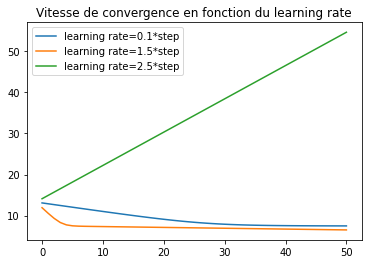

In [62]:

LR=np.array([0.1,1.5,2.5])
plt.figure()
plt.title("Vitesse de convergence en fonction du learning rate")
for learningrate in LR:
  beta,ridge=gradient_descent_ridge(X_train,y_train,lambd=2,learningrate=learningrate*step, epochs=50,epsilon=1e-3,monit=False,arret=False)
  plt.plot(np.log(ridge),label="learning rate="+str(learningrate)+"*step")
plt.legend()
plt.ylim()
plt.show()



Les résultats expérimentaux sont cohérents avec les résultats théoriques.Pour un learningrate de $2.5 \times$step l'algorithme ne converge pas, l'erreur explose tandis que lorsque l'on choisit un learning rate inférieur à $2 \times$step l'algorithme converge. Ainsi le learningrate optimal est inférieur à cette borne.

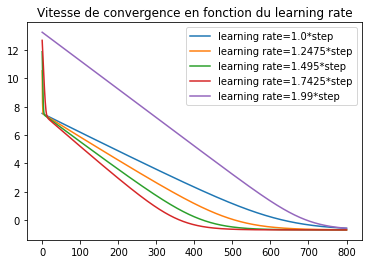

In [ ]:
LR=np.linspace(1,1.99,5)
plt.figure()
plt.title("Vitesse de convergence en fonction du learning rate")
for learningrate in LR:
  beta,ridge=gradient_descent_ridge(X_train,y_train,lambd=0.3,learningrate=learningrate*step, epochs=800,epsilon=1e-2,monit=False,arret=False)
  plt.plot(np.log(ridge),label="learning rate="+str(learningrate)+"*step")
plt.legend()
plt.ylim()
plt.show()

$1.7425 \times$Step (avec step qui correspond à l'inverse de la plus grande valeur propre) semble etre le meilleur choix pour le learningrate. En effet avec cette valeur du paramètre la convergence est plus rapide. Le learningrate optimal est dans un voisinage de cette valeur.

## Question 4

On cherche la valeur λ de la pénalité ridge optimale. Pour cela nous allons tracer l'erreur sur le test set en fonction de la valeur de λ et nous choisirons le λ qui minimise cette erreur.

L'algorithme a convergé 
L'algorithme a convergé 
L'algorithme a convergé 
L'algorithme a convergé 
L'algorithme a convergé 
L'algorithme a convergé 
L'algorithme a convergé 
L'algorithme a convergé 
L'algorithme a convergé 
L'algorithme a convergé 
L'algorithme a convergé 
L'algorithme a convergé 
L'algorithme a convergé 
L'algorithme a convergé 


<function matplotlib.pyplot.show(*args, **kw)>

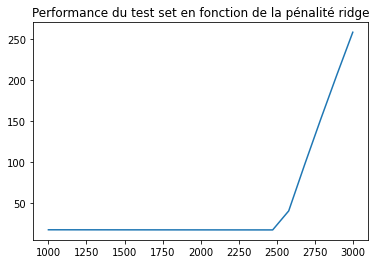

In [ ]:
LMBD=np.linspace(1000,3000,20)
error_test=[]
for lambd in LMBD:
  beta,ridge=gradient_descent_ridge(X_train,y_train,lambd=lambd,learningrate=1.3*step, epochs=1000,epsilon=1e-3,monit=False,arret=True)
  error_test.append(ridge_error(y_test,X_test,beta=beta,lambd=lambd))
plt.figure()
plt.plot( LMBD,np.log(error_test))
plt.title("Performance du test set en fonction de la pénalité ridge")
plt.show


Nous tracons ici le tableau des erreurs du le test set en fonction du paramètre λ.

In [ ]:
pd.DataFrame(error_test, index=LMBD)

,0
1000.000000,5.244026e+07
1105.263158,5.162819e+07
1210.526316,5.086497e+07
1315.789474,5.014660e+07
1421.052632,4.946946e+07
1526.315789,4.883035e+07
1631.578947,4.822636e+07
1736.842105,4.765487e+07
1842.105263,4.711352e+07
1947.368421,4.660017e+07


On remarque que :
- pour λ entre $10^3$ et $2.473 \times 10^3$ l'erreur sur le test est décroissante 
- pour λ compris entre $2.473 \times 10^3$ et $3 \times 10^3$ l'erreur sur le test est croissante. 

La valeur optimale de λ est autour de $2.473\times 10^3$, là où l'erreur sur le test set est minimale.
On répète l'expérience avec des valeurs de λ dans un voisinage de $2.473\times 10^3$.

<function matplotlib.pyplot.show(*args, **kw)>

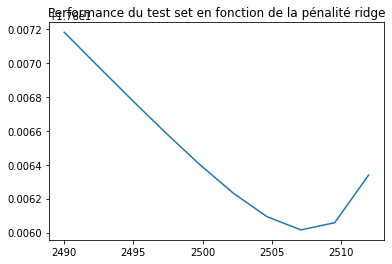

In [ ]:
LMBD=np.linspace(2.49*1e3,2.512*1e3,10)
error_test=[]
for lambd in LMBD:
  beta,ridge=gradient_descent_ridge(X_train,y_train,lambd=lambd,learningrate=1.3*step, epochs=1000,epsilon=1e-3,monit=False,arret=True)
  error_test.append(ridge_error(y_test,X_test,beta=beta,lambd=lambd))
plt.figure()
plt.plot( LMBD,np.log(error_test))
plt.title("Performance du test set en fonction de la pénalité ridge")
plt.show

On peut identifier sur le graphe ci dessus le lambda optimal. $λ_{optimal}=2507$